In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

In [2]:
random.seed(42)
torch.manual_seed(42)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


In [3]:
class SimpleNN(nn.Module):
    
    """
    A simple feedforward neural network for image classification tasks, particularly designed 
    for datasets like MNIST with 28x28 pixel grayscale images. The model consists of four 
    fully connected layers with ReLU activation functions and dropout for regularization.

    Architecture:
    - Input Layer: Takes input images reshaped into a vector of 784 features (28*28).
    - Hidden Layer 1: Fully connected layer transforming 784 features to 256 features, followed by ReLU activation and dropout.
    - Hidden Layer 2: Fully connected layer transforming 256 features to 128 features, followed by ReLU activation and dropout.
    - Hidden Layer 3: Fully connected layer transforming 128 features to 64 features, followed by ReLU activation.
    - Output Layer: Maps the 64 features to 10 output classes, suitable for classification tasks with 10 categories.

    Dropout is applied after the first two hidden layers with a 50% dropout rate to prevent 
    overfitting by randomly setting half of the neurons to zero during training.
    
    """
    
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(0.5)      # Dropout layer with 50% dropout rate

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)                 # Apply dropout after the first layer
        x = F.relu(self.fc2(x))
        x = self.dropout(x)                 # Apply dropout after the second layer
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [4]:
def train_model_with_lr_schedule(model_name, batch_size, learning_rate, num_epochs=24):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)
    
    model = SimpleNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    all_train_loss, all_train_acc = [], []  
    all_test_loss, all_test_acc = [] , []   

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct_train = 0
        total_train = 0

        # Training loop
        for data, target in tqdm(train_loader, desc=f'Training Epoch {epoch+1}/{num_epochs} (LR={learning_rate})'):
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            # Accumulate training loss
            train_loss += loss.item()
            # Calculate training accuracy
            pred = output.argmax(dim=1)
            correct_train += pred.eq(target).sum().item()
            total_train += target.size(0)
        
        # Average training loss and accuracy
        train_loss /= len(train_loader)
        train_acc = 100. * correct_train / total_train

        # Evaluate on test set
        test_loss, test_acc = test_model(model, test_loader)
        
        # Store results
        all_train_loss.append(train_loss)
        all_train_acc.append(train_acc)
        all_test_loss.append(test_loss)
        all_test_acc.append(test_acc)

        # Print the epoch details
        print(f'Model: {model_name}, Batch Size: {batch_size}, Learning Rate: {learning_rate} | '
              f'Epoch: {epoch + 1}/{num_epochs} | '
              f'Train Loss: {train_loss:.6f}, Test Loss: {test_loss:.6f}, '
              f'Train Accuracy: {train_acc:.6f}, Test Accuracy: {test_acc:.6f}')
        
    return model.state_dict(), all_train_loss, all_train_acc, all_test_loss, all_test_acc

In [5]:
def test_model(model, test_loader):
    
    model.eval()  # Set the model to evaluation mode
    test_loss = 0
    correct = 0
    
    with torch.no_grad():  # Disable gradient calculation
        for data, target in test_loader:
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # Sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    test_loss /= len(test_loader.dataset)  # Average loss over the test set
    accuracy = 100. * correct / len(test_loader.dataset)  # Accuracy percentage
    
    return test_loss, accuracy


In [6]:
def interpolate_models(params_1, params_2, alpha):
   
    interpolated_params = {}
    for key in params_1:
        interpolated_params[key] = (1 - alpha) * params_1[key] + alpha * params_2[key]
    
    return interpolated_params

In [7]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)


In [8]:
# Train Model 1 with batch size 64 and learning rate 1e-3 for 24 epochs
params_1_lr_1e3, train_loss_1_lr_1e3, train_acc_1_lr_1e3, test_loss_1_lr_1e3, test_acc_1_lr_1e3 = train_model_with_lr_schedule("Model 1", batch_size=64, learning_rate=1e-3, num_epochs=24)
# Train Model 1 with batch size 64 and learning rate 1e-2 for 24 epochs
params_1_lr_1e2, train_loss_1_lr_1e2, train_acc_1_lr_1e2, test_loss_1_lr_1e2, test_acc_1_lr_1e2 = train_model_with_lr_schedule("Model 1", batch_size=64, learning_rate=1e-2, num_epochs=24)

# Combine Model 1 Parameters
params_1_combined = {key: (params_1_lr_1e3[key] + params_1_lr_1e2[key]) / 2 for key in params_1_lr_1e3}

# Train Model 2 with batch size 1024 and learning rate 1e-3 for 24 epochs
params_2_lr_1e3, train_loss_2_lr_1e3, train_acc_2_lr_1e3, test_loss_2_lr_1e3, test_acc_2_lr_1e3 = train_model_with_lr_schedule("Model 2", batch_size=1024, learning_rate=1e-3, num_epochs=24)
# Train Model 2 with batch size 1024 and learning rate 1e-2 for 24 epochs
params_2_lr_1e2, train_loss_2_lr_1e2, train_acc_2_lr_1e2, test_loss_2_lr_1e2, test_acc_2_lr_1e2 = train_model_with_lr_schedule("Model 2", batch_size=1024, learning_rate=1e-2, num_epochs=24)

# Combine Model 2 Parameters
params_2_combined = {key: (params_2_lr_1e3[key] + params_2_lr_1e2[key]) / 2 for key in params_2_lr_1e3}

# Interpolation between the models
alphas = np.linspace(-1, 2, 30)
train_loss_values_m1, test_loss_values_m1 = [], []
train_acc_values_m1, test_acc_values_m1 = [], []


Training Epoch 1/24 (LR=0.001): 100%|██████████| 938/938 [00:05<00:00, 185.70it/s]


Model: Model 1, Batch Size: 64, Learning Rate: 0.001 | Epoch: 1/24 | Train Loss: 2.304055, Test Loss: 2.294905, Train Accuracy: 10.306667, Test Accuracy: 10.090000


Training Epoch 2/24 (LR=0.001): 100%|██████████| 938/938 [00:05<00:00, 172.20it/s]


Model: Model 1, Batch Size: 64, Learning Rate: 0.001 | Epoch: 2/24 | Train Loss: 2.292166, Test Loss: 2.279633, Train Accuracy: 13.146667, Test Accuracy: 10.840000


Training Epoch 3/24 (LR=0.001): 100%|██████████| 938/938 [00:05<00:00, 167.01it/s]


Model: Model 1, Batch Size: 64, Learning Rate: 0.001 | Epoch: 3/24 | Train Loss: 2.277116, Test Loss: 2.255447, Train Accuracy: 18.181667, Test Accuracy: 30.000000


Training Epoch 4/24 (LR=0.001): 100%|██████████| 938/938 [00:05<00:00, 172.55it/s]


Model: Model 1, Batch Size: 64, Learning Rate: 0.001 | Epoch: 4/24 | Train Loss: 2.253165, Test Loss: 2.213659, Train Accuracy: 21.123333, Test Accuracy: 34.840000


Training Epoch 5/24 (LR=0.001): 100%|██████████| 938/938 [00:04<00:00, 193.93it/s]


Model: Model 1, Batch Size: 64, Learning Rate: 0.001 | Epoch: 5/24 | Train Loss: 2.209033, Test Loss: 2.134060, Train Accuracy: 24.073333, Test Accuracy: 40.220000


Training Epoch 6/24 (LR=0.001): 100%|██████████| 938/938 [00:04<00:00, 196.25it/s]


Model: Model 1, Batch Size: 64, Learning Rate: 0.001 | Epoch: 6/24 | Train Loss: 2.124753, Test Loss: 1.983948, Train Accuracy: 29.278333, Test Accuracy: 45.340000


Training Epoch 7/24 (LR=0.001): 100%|██████████| 938/938 [00:05<00:00, 167.20it/s]


Model: Model 1, Batch Size: 64, Learning Rate: 0.001 | Epoch: 7/24 | Train Loss: 1.973624, Test Loss: 1.749222, Train Accuracy: 36.096667, Test Accuracy: 52.620000


Training Epoch 8/24 (LR=0.001): 100%|██████████| 938/938 [00:05<00:00, 163.78it/s]


Model: Model 1, Batch Size: 64, Learning Rate: 0.001 | Epoch: 8/24 | Train Loss: 1.758367, Test Loss: 1.465148, Train Accuracy: 42.970000, Test Accuracy: 60.830000


Training Epoch 9/24 (LR=0.001): 100%|██████████| 938/938 [00:05<00:00, 180.73it/s]


Model: Model 1, Batch Size: 64, Learning Rate: 0.001 | Epoch: 9/24 | Train Loss: 1.529480, Test Loss: 1.212602, Train Accuracy: 49.276667, Test Accuracy: 64.720000


Training Epoch 10/24 (LR=0.001): 100%|██████████| 938/938 [00:05<00:00, 182.09it/s]


Model: Model 1, Batch Size: 64, Learning Rate: 0.001 | Epoch: 10/24 | Train Loss: 1.333230, Test Loss: 1.037917, Train Accuracy: 54.903333, Test Accuracy: 68.960000


Training Epoch 11/24 (LR=0.001): 100%|██████████| 938/938 [00:04<00:00, 191.73it/s]


Model: Model 1, Batch Size: 64, Learning Rate: 0.001 | Epoch: 11/24 | Train Loss: 1.192220, Test Loss: 0.914634, Train Accuracy: 59.201667, Test Accuracy: 73.060000


Training Epoch 12/24 (LR=0.001): 100%|██████████| 938/938 [00:06<00:00, 152.58it/s]


Model: Model 1, Batch Size: 64, Learning Rate: 0.001 | Epoch: 12/24 | Train Loss: 1.088627, Test Loss: 0.821911, Train Accuracy: 63.135000, Test Accuracy: 75.770000


Training Epoch 13/24 (LR=0.001): 100%|██████████| 938/938 [00:04<00:00, 189.01it/s]


Model: Model 1, Batch Size: 64, Learning Rate: 0.001 | Epoch: 13/24 | Train Loss: 1.004180, Test Loss: 0.748170, Train Accuracy: 66.401667, Test Accuracy: 78.110000


Training Epoch 14/24 (LR=0.001): 100%|██████████| 938/938 [00:05<00:00, 178.60it/s]


Model: Model 1, Batch Size: 64, Learning Rate: 0.001 | Epoch: 14/24 | Train Loss: 0.933503, Test Loss: 0.681105, Train Accuracy: 69.041667, Test Accuracy: 80.300000


Training Epoch 15/24 (LR=0.001): 100%|██████████| 938/938 [00:05<00:00, 176.43it/s]


Model: Model 1, Batch Size: 64, Learning Rate: 0.001 | Epoch: 15/24 | Train Loss: 0.870282, Test Loss: 0.626874, Train Accuracy: 71.681667, Test Accuracy: 82.180000


Training Epoch 16/24 (LR=0.001): 100%|██████████| 938/938 [00:05<00:00, 166.50it/s]


Model: Model 1, Batch Size: 64, Learning Rate: 0.001 | Epoch: 16/24 | Train Loss: 0.818057, Test Loss: 0.578136, Train Accuracy: 73.528333, Test Accuracy: 83.740000


Training Epoch 17/24 (LR=0.001): 100%|██████████| 938/938 [00:05<00:00, 175.68it/s]


Model: Model 1, Batch Size: 64, Learning Rate: 0.001 | Epoch: 17/24 | Train Loss: 0.774704, Test Loss: 0.542441, Train Accuracy: 75.125000, Test Accuracy: 84.820000


Training Epoch 18/24 (LR=0.001): 100%|██████████| 938/938 [00:05<00:00, 187.21it/s]


Model: Model 1, Batch Size: 64, Learning Rate: 0.001 | Epoch: 18/24 | Train Loss: 0.733536, Test Loss: 0.508673, Train Accuracy: 76.751667, Test Accuracy: 85.780000


Training Epoch 19/24 (LR=0.001): 100%|██████████| 938/938 [00:05<00:00, 175.06it/s]


Model: Model 1, Batch Size: 64, Learning Rate: 0.001 | Epoch: 19/24 | Train Loss: 0.698011, Test Loss: 0.480953, Train Accuracy: 78.008333, Test Accuracy: 86.610000


Training Epoch 20/24 (LR=0.001): 100%|██████████| 938/938 [00:06<00:00, 154.14it/s]


Model: Model 1, Batch Size: 64, Learning Rate: 0.001 | Epoch: 20/24 | Train Loss: 0.666312, Test Loss: 0.456553, Train Accuracy: 79.170000, Test Accuracy: 87.200000


Training Epoch 21/24 (LR=0.001): 100%|██████████| 938/938 [00:05<00:00, 179.67it/s]


Model: Model 1, Batch Size: 64, Learning Rate: 0.001 | Epoch: 21/24 | Train Loss: 0.637492, Test Loss: 0.437417, Train Accuracy: 80.290000, Test Accuracy: 87.710000


Training Epoch 22/24 (LR=0.001): 100%|██████████| 938/938 [00:04<00:00, 213.32it/s]


Model: Model 1, Batch Size: 64, Learning Rate: 0.001 | Epoch: 22/24 | Train Loss: 0.615660, Test Loss: 0.418755, Train Accuracy: 81.040000, Test Accuracy: 88.220000


Training Epoch 23/24 (LR=0.001): 100%|██████████| 938/938 [00:05<00:00, 174.61it/s]


Model: Model 1, Batch Size: 64, Learning Rate: 0.001 | Epoch: 23/24 | Train Loss: 0.595865, Test Loss: 0.404696, Train Accuracy: 81.698333, Test Accuracy: 88.520000


Training Epoch 24/24 (LR=0.001): 100%|██████████| 938/938 [00:05<00:00, 168.09it/s]


Model: Model 1, Batch Size: 64, Learning Rate: 0.001 | Epoch: 24/24 | Train Loss: 0.574499, Test Loss: 0.389139, Train Accuracy: 82.473333, Test Accuracy: 88.870000


Training Epoch 1/24 (LR=0.01): 100%|██████████| 938/938 [00:05<00:00, 177.74it/s]


Model: Model 1, Batch Size: 64, Learning Rate: 0.01 | Epoch: 1/24 | Train Loss: 1.839709, Test Loss: 0.784137, Train Accuracy: 35.090000, Test Accuracy: 78.600000


Training Epoch 2/24 (LR=0.01): 100%|██████████| 938/938 [00:05<00:00, 179.15it/s]


Model: Model 1, Batch Size: 64, Learning Rate: 0.01 | Epoch: 2/24 | Train Loss: 0.753348, Test Loss: 0.415391, Train Accuracy: 75.910000, Test Accuracy: 87.850000


Training Epoch 3/24 (LR=0.01): 100%|██████████| 938/938 [00:04<00:00, 203.54it/s]


Model: Model 1, Batch Size: 64, Learning Rate: 0.01 | Epoch: 3/24 | Train Loss: 0.531098, Test Loss: 0.314147, Train Accuracy: 84.075000, Test Accuracy: 90.780000


Training Epoch 4/24 (LR=0.01): 100%|██████████| 938/938 [00:05<00:00, 175.21it/s]


Model: Model 1, Batch Size: 64, Learning Rate: 0.01 | Epoch: 4/24 | Train Loss: 0.436923, Test Loss: 0.268081, Train Accuracy: 86.883333, Test Accuracy: 92.230000


Training Epoch 5/24 (LR=0.01): 100%|██████████| 938/938 [00:04<00:00, 199.47it/s]


Model: Model 1, Batch Size: 64, Learning Rate: 0.01 | Epoch: 5/24 | Train Loss: 0.383148, Test Loss: 0.234492, Train Accuracy: 88.701667, Test Accuracy: 92.840000


Training Epoch 6/24 (LR=0.01): 100%|██████████| 938/938 [00:05<00:00, 177.58it/s]


Model: Model 1, Batch Size: 64, Learning Rate: 0.01 | Epoch: 6/24 | Train Loss: 0.343506, Test Loss: 0.214107, Train Accuracy: 89.956667, Test Accuracy: 93.600000


Training Epoch 7/24 (LR=0.01): 100%|██████████| 938/938 [00:05<00:00, 186.93it/s]


Model: Model 1, Batch Size: 64, Learning Rate: 0.01 | Epoch: 7/24 | Train Loss: 0.315205, Test Loss: 0.195931, Train Accuracy: 90.675000, Test Accuracy: 94.120000


Training Epoch 8/24 (LR=0.01): 100%|██████████| 938/938 [00:05<00:00, 181.20it/s]


Model: Model 1, Batch Size: 64, Learning Rate: 0.01 | Epoch: 8/24 | Train Loss: 0.290201, Test Loss: 0.177865, Train Accuracy: 91.530000, Test Accuracy: 94.740000


Training Epoch 9/24 (LR=0.01): 100%|██████████| 938/938 [00:04<00:00, 204.33it/s]


Model: Model 1, Batch Size: 64, Learning Rate: 0.01 | Epoch: 9/24 | Train Loss: 0.270243, Test Loss: 0.175495, Train Accuracy: 92.175000, Test Accuracy: 94.640000


Training Epoch 10/24 (LR=0.01): 100%|██████████| 938/938 [00:05<00:00, 183.30it/s]


Model: Model 1, Batch Size: 64, Learning Rate: 0.01 | Epoch: 10/24 | Train Loss: 0.255343, Test Loss: 0.155753, Train Accuracy: 92.606667, Test Accuracy: 95.310000


Training Epoch 11/24 (LR=0.01): 100%|██████████| 938/938 [00:05<00:00, 185.38it/s]


Model: Model 1, Batch Size: 64, Learning Rate: 0.01 | Epoch: 11/24 | Train Loss: 0.241681, Test Loss: 0.160240, Train Accuracy: 93.111667, Test Accuracy: 95.290000


Training Epoch 12/24 (LR=0.01): 100%|██████████| 938/938 [00:05<00:00, 186.03it/s]


Model: Model 1, Batch Size: 64, Learning Rate: 0.01 | Epoch: 12/24 | Train Loss: 0.227980, Test Loss: 0.138303, Train Accuracy: 93.276667, Test Accuracy: 95.820000


Training Epoch 13/24 (LR=0.01): 100%|██████████| 938/938 [00:05<00:00, 181.75it/s]


Model: Model 1, Batch Size: 64, Learning Rate: 0.01 | Epoch: 13/24 | Train Loss: 0.216248, Test Loss: 0.131007, Train Accuracy: 93.721667, Test Accuracy: 96.040000


Training Epoch 14/24 (LR=0.01): 100%|██████████| 938/938 [00:04<00:00, 207.19it/s]


Model: Model 1, Batch Size: 64, Learning Rate: 0.01 | Epoch: 14/24 | Train Loss: 0.208761, Test Loss: 0.126076, Train Accuracy: 93.883333, Test Accuracy: 96.150000


Training Epoch 15/24 (LR=0.01): 100%|██████████| 938/938 [00:05<00:00, 182.01it/s]


Model: Model 1, Batch Size: 64, Learning Rate: 0.01 | Epoch: 15/24 | Train Loss: 0.200648, Test Loss: 0.122476, Train Accuracy: 94.120000, Test Accuracy: 96.370000


Training Epoch 16/24 (LR=0.01): 100%|██████████| 938/938 [00:05<00:00, 183.98it/s]


Model: Model 1, Batch Size: 64, Learning Rate: 0.01 | Epoch: 16/24 | Train Loss: 0.193651, Test Loss: 0.116499, Train Accuracy: 94.426667, Test Accuracy: 96.440000


Training Epoch 17/24 (LR=0.01): 100%|██████████| 938/938 [00:05<00:00, 173.65it/s]


Model: Model 1, Batch Size: 64, Learning Rate: 0.01 | Epoch: 17/24 | Train Loss: 0.184140, Test Loss: 0.112956, Train Accuracy: 94.718333, Test Accuracy: 96.640000


Training Epoch 18/24 (LR=0.01): 100%|██████████| 938/938 [00:05<00:00, 186.26it/s]


Model: Model 1, Batch Size: 64, Learning Rate: 0.01 | Epoch: 18/24 | Train Loss: 0.179015, Test Loss: 0.110215, Train Accuracy: 94.766667, Test Accuracy: 96.670000


Training Epoch 19/24 (LR=0.01): 100%|██████████| 938/938 [00:05<00:00, 181.06it/s]


Model: Model 1, Batch Size: 64, Learning Rate: 0.01 | Epoch: 19/24 | Train Loss: 0.178523, Test Loss: 0.109580, Train Accuracy: 94.770000, Test Accuracy: 96.840000


Training Epoch 20/24 (LR=0.01): 100%|██████████| 938/938 [00:04<00:00, 213.18it/s]


Model: Model 1, Batch Size: 64, Learning Rate: 0.01 | Epoch: 20/24 | Train Loss: 0.167186, Test Loss: 0.105097, Train Accuracy: 95.165000, Test Accuracy: 96.900000


Training Epoch 21/24 (LR=0.01): 100%|██████████| 938/938 [00:05<00:00, 179.95it/s]


Model: Model 1, Batch Size: 64, Learning Rate: 0.01 | Epoch: 21/24 | Train Loss: 0.164911, Test Loss: 0.100699, Train Accuracy: 95.300000, Test Accuracy: 97.160000


Training Epoch 22/24 (LR=0.01): 100%|██████████| 938/938 [00:05<00:00, 174.40it/s]


Model: Model 1, Batch Size: 64, Learning Rate: 0.01 | Epoch: 22/24 | Train Loss: 0.159970, Test Loss: 0.101650, Train Accuracy: 95.320000, Test Accuracy: 96.870000


Training Epoch 23/24 (LR=0.01): 100%|██████████| 938/938 [00:05<00:00, 172.35it/s]


Model: Model 1, Batch Size: 64, Learning Rate: 0.01 | Epoch: 23/24 | Train Loss: 0.155163, Test Loss: 0.093616, Train Accuracy: 95.450000, Test Accuracy: 97.240000


Training Epoch 24/24 (LR=0.01): 100%|██████████| 938/938 [00:05<00:00, 162.42it/s]


Model: Model 1, Batch Size: 64, Learning Rate: 0.01 | Epoch: 24/24 | Train Loss: 0.151256, Test Loss: 0.096961, Train Accuracy: 95.601667, Test Accuracy: 97.140000


Training Epoch 1/24 (LR=0.001): 100%|██████████| 59/59 [00:03<00:00, 15.38it/s]


Model: Model 2, Batch Size: 1024, Learning Rate: 0.001 | Epoch: 1/24 | Train Loss: 2.305557, Test Loss: 2.300367, Train Accuracy: 9.921667, Test Accuracy: 10.270000


Training Epoch 2/24 (LR=0.001): 100%|██████████| 59/59 [00:04<00:00, 13.95it/s]


Model: Model 2, Batch Size: 1024, Learning Rate: 0.001 | Epoch: 2/24 | Train Loss: 2.304781, Test Loss: 2.299184, Train Accuracy: 10.148333, Test Accuracy: 10.940000


Training Epoch 3/24 (LR=0.001): 100%|██████████| 59/59 [00:04<00:00, 14.55it/s]


Model: Model 2, Batch Size: 1024, Learning Rate: 0.001 | Epoch: 3/24 | Train Loss: 2.303607, Test Loss: 2.298003, Train Accuracy: 10.583333, Test Accuracy: 11.550000


Training Epoch 4/24 (LR=0.001): 100%|██████████| 59/59 [00:04<00:00, 13.22it/s]


Model: Model 2, Batch Size: 1024, Learning Rate: 0.001 | Epoch: 4/24 | Train Loss: 2.302252, Test Loss: 2.296826, Train Accuracy: 10.775000, Test Accuracy: 12.380000


Training Epoch 5/24 (LR=0.001): 100%|██████████| 59/59 [00:04<00:00, 12.94it/s]


Model: Model 2, Batch Size: 1024, Learning Rate: 0.001 | Epoch: 5/24 | Train Loss: 2.300998, Test Loss: 2.295647, Train Accuracy: 11.261667, Test Accuracy: 13.210000


Training Epoch 6/24 (LR=0.001): 100%|██████████| 59/59 [00:04<00:00, 13.10it/s]


Model: Model 2, Batch Size: 1024, Learning Rate: 0.001 | Epoch: 6/24 | Train Loss: 2.300813, Test Loss: 2.294467, Train Accuracy: 11.156667, Test Accuracy: 14.210000


Training Epoch 7/24 (LR=0.001): 100%|██████████| 59/59 [00:04<00:00, 14.15it/s]


Model: Model 2, Batch Size: 1024, Learning Rate: 0.001 | Epoch: 7/24 | Train Loss: 2.300109, Test Loss: 2.293286, Train Accuracy: 11.293333, Test Accuracy: 15.090000


Training Epoch 8/24 (LR=0.001): 100%|██████████| 59/59 [00:03<00:00, 15.18it/s]


Model: Model 2, Batch Size: 1024, Learning Rate: 0.001 | Epoch: 8/24 | Train Loss: 2.298556, Test Loss: 2.292099, Train Accuracy: 11.810000, Test Accuracy: 15.820000


Training Epoch 9/24 (LR=0.001): 100%|██████████| 59/59 [00:04<00:00, 14.56it/s]


Model: Model 2, Batch Size: 1024, Learning Rate: 0.001 | Epoch: 9/24 | Train Loss: 2.297640, Test Loss: 2.290912, Train Accuracy: 11.773333, Test Accuracy: 16.150000


Training Epoch 10/24 (LR=0.001): 100%|██████████| 59/59 [00:04<00:00, 12.02it/s]


Model: Model 2, Batch Size: 1024, Learning Rate: 0.001 | Epoch: 10/24 | Train Loss: 2.296589, Test Loss: 2.289732, Train Accuracy: 12.100000, Test Accuracy: 16.110000


Training Epoch 11/24 (LR=0.001): 100%|██████████| 59/59 [00:04<00:00, 14.07it/s]


Model: Model 2, Batch Size: 1024, Learning Rate: 0.001 | Epoch: 11/24 | Train Loss: 2.295152, Test Loss: 2.288524, Train Accuracy: 12.320000, Test Accuracy: 15.940000


Training Epoch 12/24 (LR=0.001): 100%|██████████| 59/59 [00:04<00:00, 14.32it/s]


Model: Model 2, Batch Size: 1024, Learning Rate: 0.001 | Epoch: 12/24 | Train Loss: 2.294338, Test Loss: 2.287308, Train Accuracy: 12.605000, Test Accuracy: 15.690000


Training Epoch 13/24 (LR=0.001): 100%|██████████| 59/59 [00:04<00:00, 13.74it/s]


Model: Model 2, Batch Size: 1024, Learning Rate: 0.001 | Epoch: 13/24 | Train Loss: 2.292970, Test Loss: 2.286069, Train Accuracy: 13.123333, Test Accuracy: 15.430000


Training Epoch 14/24 (LR=0.001): 100%|██████████| 59/59 [00:04<00:00, 13.37it/s]


Model: Model 2, Batch Size: 1024, Learning Rate: 0.001 | Epoch: 14/24 | Train Loss: 2.292535, Test Loss: 2.284834, Train Accuracy: 12.893333, Test Accuracy: 15.210000


Training Epoch 15/24 (LR=0.001): 100%|██████████| 59/59 [00:03<00:00, 15.27it/s]


Model: Model 2, Batch Size: 1024, Learning Rate: 0.001 | Epoch: 15/24 | Train Loss: 2.291212, Test Loss: 2.283587, Train Accuracy: 13.093333, Test Accuracy: 14.990000


Training Epoch 16/24 (LR=0.001): 100%|██████████| 59/59 [00:03<00:00, 17.49it/s]


Model: Model 2, Batch Size: 1024, Learning Rate: 0.001 | Epoch: 16/24 | Train Loss: 2.290249, Test Loss: 2.282336, Train Accuracy: 13.445000, Test Accuracy: 14.910000


Training Epoch 17/24 (LR=0.001): 100%|██████████| 59/59 [00:04<00:00, 14.44it/s]


Model: Model 2, Batch Size: 1024, Learning Rate: 0.001 | Epoch: 17/24 | Train Loss: 2.288998, Test Loss: 2.281069, Train Accuracy: 13.488333, Test Accuracy: 14.830000


Training Epoch 18/24 (LR=0.001): 100%|██████████| 59/59 [00:04<00:00, 13.57it/s]


Model: Model 2, Batch Size: 1024, Learning Rate: 0.001 | Epoch: 18/24 | Train Loss: 2.287853, Test Loss: 2.279774, Train Accuracy: 13.708333, Test Accuracy: 14.780000


Training Epoch 19/24 (LR=0.001): 100%|██████████| 59/59 [00:04<00:00, 11.97it/s]


Model: Model 2, Batch Size: 1024, Learning Rate: 0.001 | Epoch: 19/24 | Train Loss: 2.286666, Test Loss: 2.278448, Train Accuracy: 13.826667, Test Accuracy: 14.890000


Training Epoch 20/24 (LR=0.001): 100%|██████████| 59/59 [00:04<00:00, 12.70it/s]


Model: Model 2, Batch Size: 1024, Learning Rate: 0.001 | Epoch: 20/24 | Train Loss: 2.285997, Test Loss: 2.277130, Train Accuracy: 14.045000, Test Accuracy: 15.060000


Training Epoch 21/24 (LR=0.001): 100%|██████████| 59/59 [00:04<00:00, 14.55it/s]


Model: Model 2, Batch Size: 1024, Learning Rate: 0.001 | Epoch: 21/24 | Train Loss: 2.284655, Test Loss: 2.275750, Train Accuracy: 14.318333, Test Accuracy: 15.140000


Training Epoch 22/24 (LR=0.001): 100%|██████████| 59/59 [00:04<00:00, 13.78it/s]


Model: Model 2, Batch Size: 1024, Learning Rate: 0.001 | Epoch: 22/24 | Train Loss: 2.283345, Test Loss: 2.274353, Train Accuracy: 14.531667, Test Accuracy: 15.300000


Training Epoch 23/24 (LR=0.001): 100%|██████████| 59/59 [00:03<00:00, 15.21it/s]


Model: Model 2, Batch Size: 1024, Learning Rate: 0.001 | Epoch: 23/24 | Train Loss: 2.282379, Test Loss: 2.272915, Train Accuracy: 14.455000, Test Accuracy: 15.440000


Training Epoch 24/24 (LR=0.001): 100%|██████████| 59/59 [00:04<00:00, 12.77it/s]


Model: Model 2, Batch Size: 1024, Learning Rate: 0.001 | Epoch: 24/24 | Train Loss: 2.281340, Test Loss: 2.271439, Train Accuracy: 14.790000, Test Accuracy: 15.700000


Training Epoch 1/24 (LR=0.01): 100%|██████████| 59/59 [00:04<00:00, 12.72it/s]


Model: Model 2, Batch Size: 1024, Learning Rate: 0.01 | Epoch: 1/24 | Train Loss: 2.301853, Test Loss: 2.290893, Train Accuracy: 10.521667, Test Accuracy: 10.760000


Training Epoch 2/24 (LR=0.01): 100%|██████████| 59/59 [00:04<00:00, 13.30it/s]


Model: Model 2, Batch Size: 1024, Learning Rate: 0.01 | Epoch: 2/24 | Train Loss: 2.289618, Test Loss: 2.274156, Train Accuracy: 12.281667, Test Accuracy: 17.330000


Training Epoch 3/24 (LR=0.01): 100%|██████████| 59/59 [00:04<00:00, 14.32it/s]


Model: Model 2, Batch Size: 1024, Learning Rate: 0.01 | Epoch: 3/24 | Train Loss: 2.276457, Test Loss: 2.254119, Train Accuracy: 15.446667, Test Accuracy: 29.350000


Training Epoch 4/24 (LR=0.01): 100%|██████████| 59/59 [00:04<00:00, 13.66it/s]


Model: Model 2, Batch Size: 1024, Learning Rate: 0.01 | Epoch: 4/24 | Train Loss: 2.259604, Test Loss: 2.227118, Train Accuracy: 19.231667, Test Accuracy: 32.580000


Training Epoch 5/24 (LR=0.01): 100%|██████████| 59/59 [00:03<00:00, 15.41it/s]


Model: Model 2, Batch Size: 1024, Learning Rate: 0.01 | Epoch: 5/24 | Train Loss: 2.237049, Test Loss: 2.188551, Train Accuracy: 21.920000, Test Accuracy: 37.110000


Training Epoch 6/24 (LR=0.01): 100%|██████████| 59/59 [00:03<00:00, 17.57it/s]


Model: Model 2, Batch Size: 1024, Learning Rate: 0.01 | Epoch: 6/24 | Train Loss: 2.202245, Test Loss: 2.130228, Train Accuracy: 25.050000, Test Accuracy: 41.100000


Training Epoch 7/24 (LR=0.01): 100%|██████████| 59/59 [00:03<00:00, 17.54it/s]


Model: Model 2, Batch Size: 1024, Learning Rate: 0.01 | Epoch: 7/24 | Train Loss: 2.150775, Test Loss: 2.042987, Train Accuracy: 27.830000, Test Accuracy: 44.230000


Training Epoch 8/24 (LR=0.01): 100%|██████████| 59/59 [00:03<00:00, 15.32it/s]


Model: Model 2, Batch Size: 1024, Learning Rate: 0.01 | Epoch: 8/24 | Train Loss: 2.069505, Test Loss: 1.914250, Train Accuracy: 32.056667, Test Accuracy: 48.060000


Training Epoch 9/24 (LR=0.01): 100%|██████████| 59/59 [00:04<00:00, 14.29it/s]


Model: Model 2, Batch Size: 1024, Learning Rate: 0.01 | Epoch: 9/24 | Train Loss: 1.953972, Test Loss: 1.744435, Train Accuracy: 37.278333, Test Accuracy: 52.290000


Training Epoch 10/24 (LR=0.01): 100%|██████████| 59/59 [00:04<00:00, 13.98it/s]


Model: Model 2, Batch Size: 1024, Learning Rate: 0.01 | Epoch: 10/24 | Train Loss: 1.800793, Test Loss: 1.543831, Train Accuracy: 42.676667, Test Accuracy: 56.520000


Training Epoch 11/24 (LR=0.01): 100%|██████████| 59/59 [00:04<00:00, 14.16it/s]


Model: Model 2, Batch Size: 1024, Learning Rate: 0.01 | Epoch: 11/24 | Train Loss: 1.633982, Test Loss: 1.346665, Train Accuracy: 47.186667, Test Accuracy: 59.620000


Training Epoch 12/24 (LR=0.01): 100%|██████████| 59/59 [00:03<00:00, 15.00it/s]


Model: Model 2, Batch Size: 1024, Learning Rate: 0.01 | Epoch: 12/24 | Train Loss: 1.475194, Test Loss: 1.185469, Train Accuracy: 50.933333, Test Accuracy: 62.590000


Training Epoch 13/24 (LR=0.01): 100%|██████████| 59/59 [00:04<00:00, 13.61it/s]


Model: Model 2, Batch Size: 1024, Learning Rate: 0.01 | Epoch: 13/24 | Train Loss: 1.341103, Test Loss: 1.063352, Train Accuracy: 54.740000, Test Accuracy: 65.520000


Training Epoch 14/24 (LR=0.01): 100%|██████████| 59/59 [00:03<00:00, 14.83it/s]


Model: Model 2, Batch Size: 1024, Learning Rate: 0.01 | Epoch: 14/24 | Train Loss: 1.237170, Test Loss: 0.971136, Train Accuracy: 57.913333, Test Accuracy: 68.470000


Training Epoch 15/24 (LR=0.01): 100%|██████████| 59/59 [00:03<00:00, 16.19it/s]


Model: Model 2, Batch Size: 1024, Learning Rate: 0.01 | Epoch: 15/24 | Train Loss: 1.156800, Test Loss: 0.898201, Train Accuracy: 60.495000, Test Accuracy: 71.710000


Training Epoch 16/24 (LR=0.01): 100%|██████████| 59/59 [00:03<00:00, 14.87it/s]


Model: Model 2, Batch Size: 1024, Learning Rate: 0.01 | Epoch: 16/24 | Train Loss: 1.085038, Test Loss: 0.837926, Train Accuracy: 63.018333, Test Accuracy: 73.700000


Training Epoch 17/24 (LR=0.01): 100%|██████████| 59/59 [00:04<00:00, 13.69it/s]


Model: Model 2, Batch Size: 1024, Learning Rate: 0.01 | Epoch: 17/24 | Train Loss: 1.029513, Test Loss: 0.787456, Train Accuracy: 65.301667, Test Accuracy: 76.270000


Training Epoch 18/24 (LR=0.01): 100%|██████████| 59/59 [00:04<00:00, 13.93it/s]


Model: Model 2, Batch Size: 1024, Learning Rate: 0.01 | Epoch: 18/24 | Train Loss: 0.983454, Test Loss: 0.741771, Train Accuracy: 67.071667, Test Accuracy: 77.790000


Training Epoch 19/24 (LR=0.01): 100%|██████████| 59/59 [00:04<00:00, 14.21it/s]


Model: Model 2, Batch Size: 1024, Learning Rate: 0.01 | Epoch: 19/24 | Train Loss: 0.940531, Test Loss: 0.702522, Train Accuracy: 68.688333, Test Accuracy: 79.440000


Training Epoch 20/24 (LR=0.01): 100%|██████████| 59/59 [00:04<00:00, 13.77it/s]


Model: Model 2, Batch Size: 1024, Learning Rate: 0.01 | Epoch: 20/24 | Train Loss: 0.898220, Test Loss: 0.666130, Train Accuracy: 70.390000, Test Accuracy: 80.560000


Training Epoch 21/24 (LR=0.01): 100%|██████████| 59/59 [00:04<00:00, 14.54it/s]


Model: Model 2, Batch Size: 1024, Learning Rate: 0.01 | Epoch: 21/24 | Train Loss: 0.864101, Test Loss: 0.634003, Train Accuracy: 71.288333, Test Accuracy: 81.510000


Training Epoch 22/24 (LR=0.01): 100%|██████████| 59/59 [00:03<00:00, 17.41it/s]


Model: Model 2, Batch Size: 1024, Learning Rate: 0.01 | Epoch: 22/24 | Train Loss: 0.831205, Test Loss: 0.606966, Train Accuracy: 72.718333, Test Accuracy: 82.610000


Training Epoch 23/24 (LR=0.01): 100%|██████████| 59/59 [00:03<00:00, 17.60it/s]


Model: Model 2, Batch Size: 1024, Learning Rate: 0.01 | Epoch: 23/24 | Train Loss: 0.803594, Test Loss: 0.578334, Train Accuracy: 74.030000, Test Accuracy: 83.580000


Training Epoch 24/24 (LR=0.01): 100%|██████████| 59/59 [00:04<00:00, 13.95it/s]


Model: Model 2, Batch Size: 1024, Learning Rate: 0.01 | Epoch: 24/24 | Train Loss: 0.773839, Test Loss: 0.553194, Train Accuracy: 75.063333, Test Accuracy: 84.350000


In [9]:
# Model 1 Evaluation
for alpha in alphas:
    interpolated_params = interpolate_models(params_1_lr_1e3, params_1_lr_1e2, alpha)
    
    model = SimpleNN()
    model.load_state_dict(interpolated_params)
    
    # Evaluate train and test loss and accuracy for model 1
    train_loss, train_acc = test_model(model, DataLoader(train_dataset, batch_size=1000, shuffle=False))
    test_loss, test_acc = test_model(model, DataLoader(test_dataset, batch_size=1000, shuffle=False))
    
    train_loss_values_m1.append(train_loss)
    test_loss_values_m1.append(test_loss)
    train_acc_values_m1.append(train_acc)
    test_acc_values_m1.append(test_acc)

# Model 2 Evaluation
train_loss_values_m2, test_loss_values_m2 = [], []
train_acc_values_m2, test_acc_values_m2 = [], []

for alpha in alphas:
    interpolated_params = interpolate_models(params_2_lr_1e3, params_2_lr_1e2, alpha)
    
    model = SimpleNN()
    model.load_state_dict(interpolated_params)
    
    # Evaluate train and test loss and accuracy for model 2
    train_loss, train_acc = test_model(model, DataLoader(train_dataset, batch_size=1000, shuffle=False))
    test_loss, test_acc = test_model(model, DataLoader(test_dataset, batch_size=1000, shuffle=False))
    
    train_loss_values_m2.append(train_loss)
    test_loss_values_m2.append(test_loss)
    train_acc_values_m2.append(train_acc)
    test_acc_values_m2.append(test_acc)


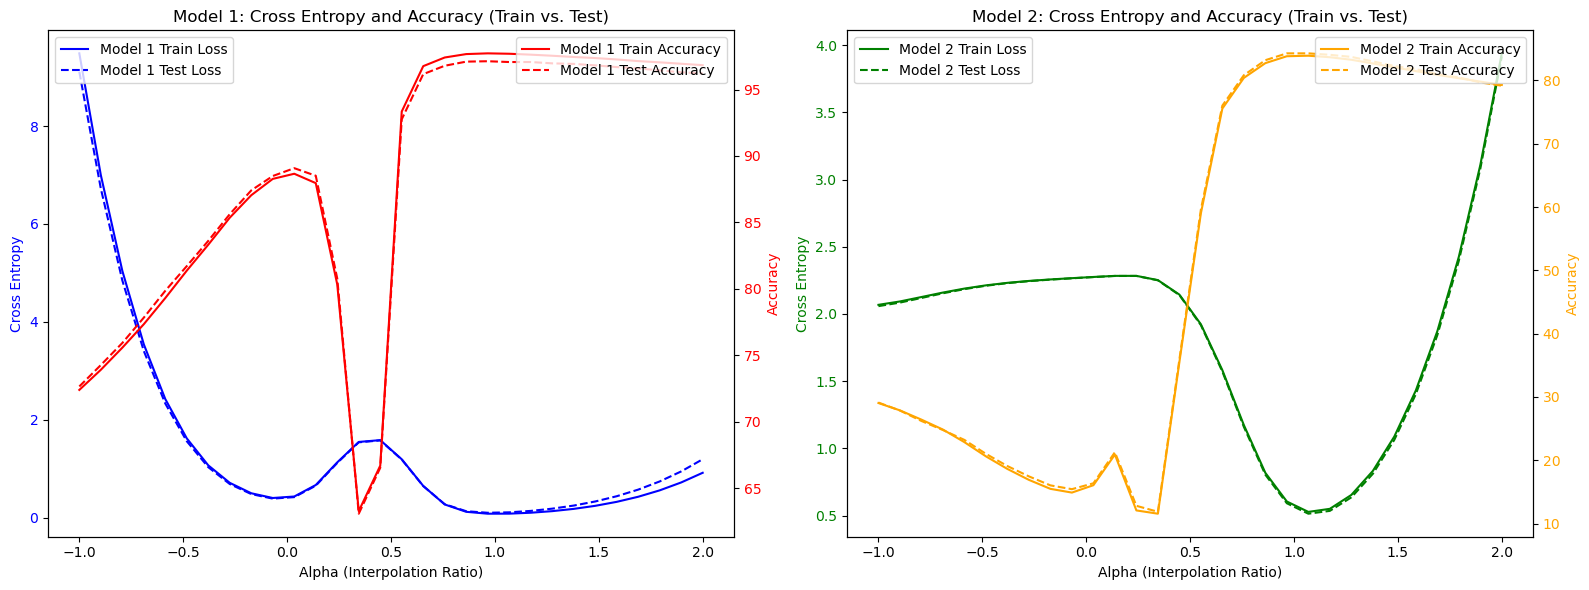

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Model 1 Plot (m1)
ax1.set_xlabel('Alpha (Interpolation Ratio)')
ax1.set_ylabel('Cross Entropy', color='blue')
ax1.plot(alphas, train_loss_values_m1, label='Model 1 Train Loss', color='blue', linestyle='-')
ax1.plot(alphas, test_loss_values_m1, label='Model 1 Test Loss', color='blue', linestyle='--')
ax1.tick_params(axis='y', labelcolor='blue')

ax1_twin = ax1.twinx()  # instantiate a second y-axis for accuracy
ax1_twin.set_ylabel('Accuracy', color='red')
ax1_twin.plot(alphas, train_acc_values_m1, label='Model 1 Train Accuracy', color='red', linestyle='-')
ax1_twin.plot(alphas, test_acc_values_m1, label='Model 1 Test Accuracy', color='red', linestyle='--')
ax1_twin.tick_params(axis='y', labelcolor='red')

ax1.set_title('Model 1: Cross Entropy and Accuracy (Train vs. Test)')
ax1.legend(loc='upper left')
ax1_twin.legend(loc='upper right')

# Model 2 Plot (m2)
ax2.set_xlabel('Alpha (Interpolation Ratio)')
ax2.set_ylabel('Cross Entropy', color='green')
ax2.plot(alphas, train_loss_values_m2, label='Model 2 Train Loss', color='green', linestyle='-')
ax2.plot(alphas, test_loss_values_m2, label='Model 2 Test Loss', color='green', linestyle='--')
ax2.tick_params(axis='y', labelcolor='green')

ax2_twin = ax2.twinx()  # instantiate a second y-axis for accuracy
ax2_twin.set_ylabel('Accuracy', color='orange')
ax2_twin.plot(alphas, train_acc_values_m2, label='Model 2 Train Accuracy', color='orange', linestyle='-')
ax2_twin.plot(alphas, test_acc_values_m2, label='Model 2 Test Accuracy', color='orange', linestyle='--')
ax2_twin.tick_params(axis='y', labelcolor='orange')

ax2.set_title('Model 2: Cross Entropy and Accuracy (Train vs. Test)')
ax2.legend(loc='upper left')
ax2_twin.legend(loc='upper right')

plt.tight_layout()
plt.show()